## 0. Imports and Setup

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotly import express as px

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
modelling_data_7_steps = pd.read_csv('clp_usd_modelling_data_7_days.csv', index_col = 0, parse_dates=True)
modelling_data_30_steps = pd.read_csv('clp_usd_modelling_data_30_days.csv', index_col = 0, parse_dates=True)

In [3]:
def sign_match(y_true, y_pred, return_matrix = True):
    '''Ths should be a good enough metrics if using the predictions
    for trading: buying in and sell.
    i.e. as long as the direction is right, this could be 
    quite useful already'''
    from sklearn.metrics import confusion_matrix
    
    y_true_binary = np.where(y_true>0, 1, 0)
    y_pred_binary = np.where(y_pred >0, 1, 0)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    sign_match_score = (cm[0][0] + cm[1][1])/ (cm[0][0] + cm[1][1] + cm[1][0] + cm[0][1])

    if return_matrix==True:
        return sign_match_score, cm
    else:
        return sign_match_score

## 1. Persistant model as a benchmark model
Note:
Past value is the future value. This actually can be a very strong model to beat

In [4]:
modelling_data_7_days_benchmark_data = modelling_data_7_steps.assign(
    truth = lambda d: d['CLPUSD_wins'].pct_change(7).shift(-7),
    naiive_pred = lambda d: d['CLPUSD_wins'].pct_change(7),
)

modelling_data_30_days_benchmark_data = modelling_data_30_steps.assign(
    truth = lambda d: d['CLPUSD_wins'].pct_change(30).shift(-30),
    naiive_pred = lambda d: d['CLPUSD_wins'].pct_change(30),
)

## 2. Fitting the model, Cross-Validation etc, normal ML process

### 2.1 CLP/USD 7-steps return, 7 step ahead

In [5]:
modelling_data_7_steps = modelling_data_7_steps.assign(
    modelling_target = lambda d: d['CLPUSD_wins'].shift(-7).pct_change(7))\
    .drop(columns=['CLPUSD_wins'])\
    .replace([np.inf, -np.inf],  np.nan)\
    .dropna()

In [6]:
end_of_training= '2021-06-01' # ROUGHLY 60% TRAINING, 40% TESTING SPLIT - leave 2 years window untouched
# SAME AS BEFORE

X_7 = modelling_data_7_steps.drop(columns=['modelling_target'])
y_7 = modelling_data_7_steps['modelling_target']

# Splitting - leave something out completely untouched by the process to evalute its true performance
X_train_7, y_train_7 = X_7.loc[:end_of_training], y_7[:end_of_training]
X_holdout_7, y_holdout_7 = X_7.loc[end_of_training:], y_7[end_of_training:]

# Scaled the data
scaler = StandardScaler()
X_train_7_scaled  = pd.DataFrame(scaler.fit_transform(X_train_7), columns= X_train_7.columns)
X_holdout_7_scaled = pd.DataFrame(scaler.transform(X_holdout_7), columns=X_holdout_7.columns)

In [7]:
# Setting some constraints - maybe there will be some gains
monotonic_cst={
    # "yield_spread_Chile_US_10Y 14-step return": 1, # probably not deteriministic yet
    "import_export_total_Chile 30-step return": 1,  # higher demand for Chilean currency, more USD for 1 PESO
    'S&P CLX IPSA 14-step difference': 1, # Good Chilean market - stronger Chilean economy - Stronger currency
    # 'Chicago Fed National Financial Conditions Index 7-step difference': 1, # better invsetor confidence, better us economy, more peso needed for usd
              }

In [8]:
# Candiate models - GB works well out of the box - using the hist deravatives as it can allow me to insert constaints
# maybe constraining it helps a bit
models = {
    'HGB_no_constraints': HistGradientBoostingRegressor(random_state = 2023,
                                                        max_iter=1000), # without any constraints
    'HGB_constraints': HistGradientBoostingRegressor(random_state = 2023,
                                                     monotonic_cst=monotonic_cst,
                                                     max_iter=1000
                                                     ) # see if I could improve its performance by constraining soem features
}

# Do some grid search
param_grids = {
    'HGB_no_constraints': {
        'max_depth': [None, 4, 6, 8, 10],
        'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
        'max_leaf_nodes': [3, 6, 12, 18],
    },
    'HGB_constraints': {
        'max_depth': [None, 4, 6, 8, 10],
        'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
        'max_leaf_nodes': [3, 6, 12, 18],
    }
}

In [73]:
# Perform time series cross-validation for each model
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

best_models = {}
ts_cv = TimeSeriesSplit(n_splits=5)
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=ts_cv)
    grid_search.fit(X_train_7_scaled, y_train_7)
    best_models[model_name] = grid_search.best_estimator_

In [74]:
# Evaluate the best models on the holdout period
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_holdout_7_scaled)
    mse = mean_squared_error(y_holdout_7, y_pred)
    sign_match_score = sign_match(y_pred, y_holdout_7, return_matrix=False)
    print(f"{model_name} - MSE on Holdout Set: {mse}")
    print(f"{model_name} - Sign Match on Holdout Set: {sign_match_score}")

HGB_no_constraints - MSE on Holdout Set: 0.00036572015354994364
HGB_no_constraints - Sign Match on Holdout Set: 0.5682382133995038
HGB_constraints - MSE on Holdout Set: 0.0003669135364215201
HGB_constraints - Sign Match on Holdout Set: 0.5595533498759305


In [80]:
import pickle

with open('7_days_HGB_model.pkl', 'wb') as f:
    pickle.dump(best_models['HGB_no_constraints'], f)

with open('7_days_HGB_model_constraints.pkl', 'wb') as f:
    pickle.dump(best_models['HGB_constraints'], f)

### 2.2 CLP/USD 30-step return, 30 steps ahead

In [9]:
modelling_data_30_steps = modelling_data_30_steps.assign(
    modelling_target = lambda d: d['CLPUSD_wins'].shift(-30).pct_change(30))\
    .drop(columns=['CLPUSD_wins'])\
    .replace([np.inf, -np.inf],  np.nan)\
    .dropna()

In [10]:
X_30 = modelling_data_30_steps.drop(columns=['modelling_target'])
y_30 = modelling_data_30_steps['modelling_target']

# Splitting - leave something out completely untouched by the process to evalute its true performance
X_train_30, y_train_30 = X_30.loc[:end_of_training], y_30[:end_of_training]
X_holdout_30, y_holdout_30 = X_30.loc[end_of_training:], y_30[end_of_training:]

# Scaled the data
scaler = StandardScaler()
X_train_30_scaled  = pd.DataFrame(scaler.fit_transform(X_train_30), columns= X_train_30.columns)
X_holdout_30_scaled = pd.DataFrame(scaler.transform(X_holdout_30), columns=X_holdout_30.columns)

In [11]:
X_train_30_scaled.columns

Index(['GDP_United States 270-step difference',
       'yield_spread_30Y_6M 30-step return',
       'GDP_QoQ_diff_Chile_US 90-step difference',
       'Imports in goods (value)_United States 30-step difference',
       'yield_spread_Chile_US_10Y 30-step difference',
       'BBG_Soybeans_Index 90-step return',
       'BBG_Cocoa_Index 60-step difference',
       'import_export_total_Chile 30-step difference',
       'Consumer Price Index: All Items: Total: Total for Chile 30-step difference',
       'BBG_Copper_Index 60-step difference'],
      dtype='object')

In [12]:
len(X_train_30_scaled.columns)

10

In [22]:
# Define the parameter grid for the grid search
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
}
tscv = TimeSeriesSplit(n_splits=5)
gbm = GradientBoostingRegressor(n_estimators=3000, max_depth=5)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=tscv)
grid_search.fit(X_train_30_scaled, y_train_30)

# Print the best parameters and corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.1}
Best Score:  -0.24852798986735358


In [27]:
grid_search.best_estimator_

GradientBoostingRegressor(learning_rate=0.005, max_depth=5, n_estimators=3000)

In [30]:
# Evaluate the best models on the holdout period
y_pred = grid_search.best_estimator_.predict(X_holdout_30_scaled)
mse = mean_squared_error(y_holdout_30, y_pred)
sign_match_score = sign_match(y_pred, y_holdout_7, return_matrix=False)
print(mse, sign_match_score)


0.0015512505930787793 0.5384615384615384


## 3. Model Evaluation

### 3.1 Create predictions dataframe (along with benchamark pred)

In [209]:
clpusd_7_days_model = best_models['HGB_no_constraints']

train_7_days_pred = clpusd_7_days_model.predict(X_train_7_scaled)
holdout_7_days_pred = clpusd_7_days_model.predict(X_holdout_7_scaled)

clpusd_7_days_pred_df = pd.concat(
    [
        pd.DataFrame(
        {'datestamp': y_train_7.index,
         'y_true': y_train_7,
         'y_pred': train_7_days_pred
        }),
        pd.DataFrame(
            {
            'datestamp': y_holdout_7.index,
            'y_true': y_holdout_7,
            'y_pred': holdout_7_days_pred
            }
        )
            ])\
    .set_index('datestamp')\
              .join(modelling_data_7_days_benchmark_data['naiive_pred'])

clpusd_7_days_pred_df['period'] = np.where(clpusd_7_days_pred_df.index <= end_of_training, 'In-Sample', 'Out-of-Sample')
clpusd_7_days_pred_df.head()

,y_true,y_pred,naiive_pred,period
2015-03-31,0.024436,0.002824,-0.004367,In-Sample
2015-04-01,0.023706,0.003831,-0.003109,In-Sample
2015-04-02,0.009870,0.003608,0.006207,In-Sample
2015-04-03,-0.000615,0.003795,0.011831,In-Sample
2015-04-04,-0.000615,0.003795,0.011831,In-Sample


In [322]:
clpusd_30_days_model = grid_search.best_estimator_

train_30_days_pred = clpusd_30_days_model.predict(X_train_30_scaled)
holdout_30_days_pred = clpusd_30_days_model.predict(X_holdout_30_scaled)

clpusd_30_days_pred_df = pd.concat(
    [
        pd.DataFrame(
        {'datestamp': y_train_30.index,
         'y_true': y_train_30,
         'y_pred': train_30_days_pred
        }),
        pd.DataFrame(
            {
            'datestamp': y_holdout_30.index,
            'y_true': y_holdout_30,
            'y_pred': holdout_30_days_pred
            }
        )
            ])\
    .set_index('datestamp')\
              .join(modelling_data_30_days_benchmark_data['naiive_pred'])

clpusd_30_days_pred_df['period'] = np.where(clpusd_30_days_pred_df.index <= end_of_training, 'In-Sample', 'Out-of-Sample')
clpusd_30_days_pred_df.head()

,y_true,y_pred,naiive_pred,period
2015-09-27,0.007967,-0.001444,-0.011301,In-Sample
2015-09-28,0.009330,0.006139,-0.012637,In-Sample
2015-09-29,0.009715,0.007048,-0.006275,In-Sample
2015-09-30,0.008328,0.012366,-0.005521,In-Sample
2015-10-01,0.008538,0.015619,-0.005728,In-Sample


### 3.2 View model predictions - General Model performance

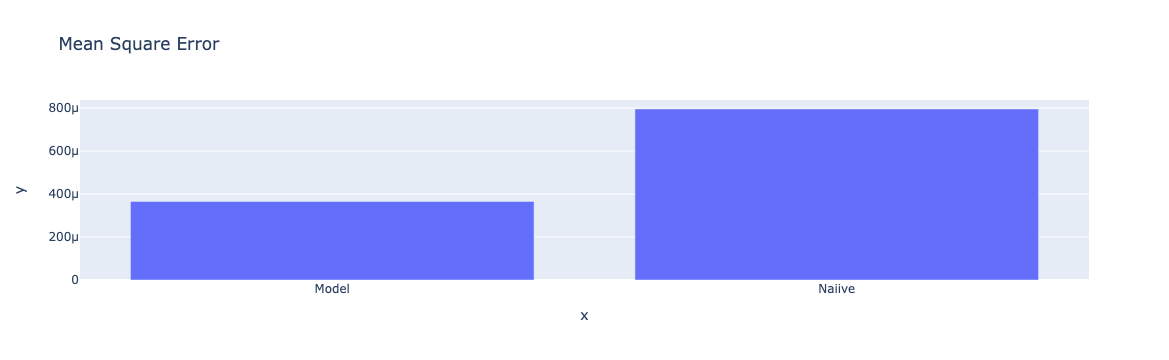

In [168]:
# MSE
from sklearn.metrics import mean_squared_error
px.bar(x=['Model', 'Naiive'], 
       y = [mean_squared_error(clpusd_7_days_pred_df.loc[end_of_training:]['y_true'], 
                                   clpusd_7_days_pred_df.loc[end_of_training:]['y_pred']), 
                mean_squared_error(clpusd_7_days_pred_df.loc[end_of_training:]['y_true'], 
                                   clpusd_7_days_pred_df.loc[end_of_training:]['naiive_pred'])],
      width = 500,
      title='Mean Square Error')

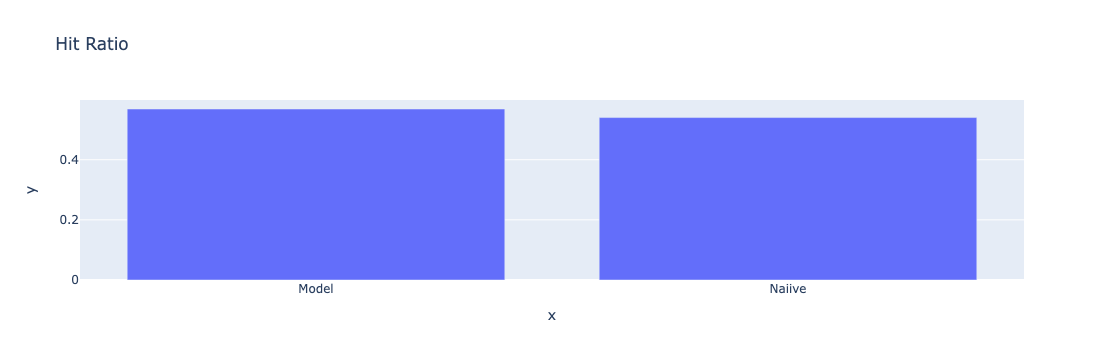

In [177]:
# HIT RATIO
px.bar(x=['Model', 'Naiive'], 
       y = [sign_match(clpusd_7_days_pred_df.loc[end_of_training:]['y_true'], 
                       clpusd_7_days_pred_df.loc[end_of_training:]['y_pred'],
                       return_matrix=False), 
                sign_match(clpusd_7_days_pred_df.loc[end_of_training:]['y_true'], 
                       clpusd_7_days_pred_df.loc[end_of_training:]['naiive_pred'],
                       return_matrix=False)],
      width = 500,
      title='Hit Ratio')

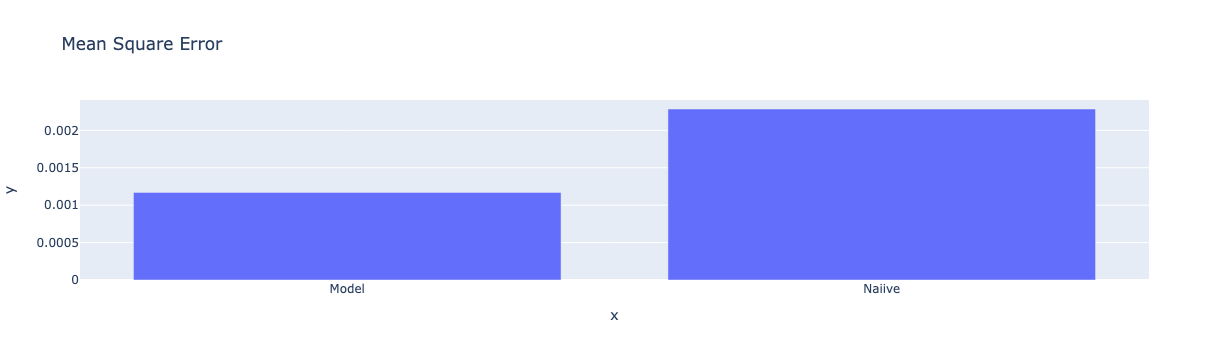

In [323]:
# MSE - 30 DAYS
from sklearn.metrics import mean_squared_error
px.bar(x=['Model', 'Naiive'], 
       y = [mean_squared_error(clpusd_30_days_pred_df.loc[end_of_training:]['y_true'], 
                                   clpusd_30_days_pred_df.loc[end_of_training:]['y_pred']), 
                mean_squared_error(clpusd_30_days_pred_df.loc[end_of_training:]['y_true'], 
                                   clpusd_30_days_pred_df.loc[end_of_training:]['naiive_pred'])],
      width = 500,
      title='Mean Square Error')

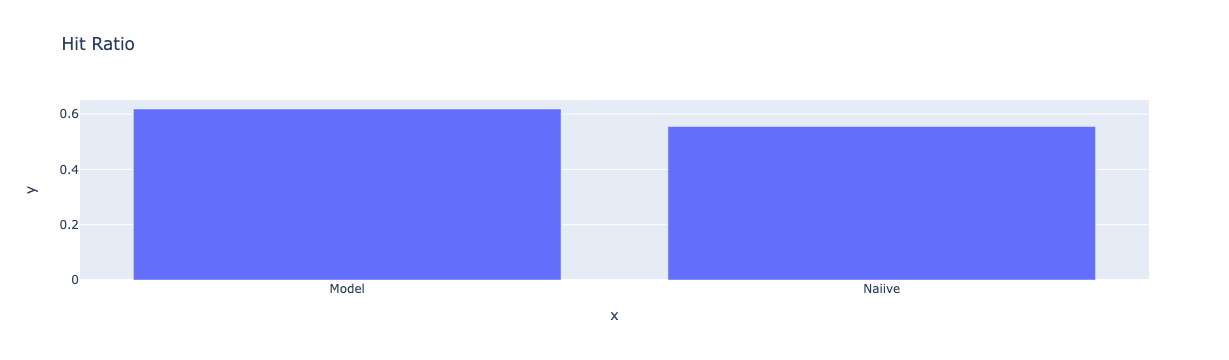

In [324]:
# HIT RATIO
px.bar(x=['Model', 'Naiive'], 
       y = [sign_match(clpusd_30_days_pred_df.loc[end_of_training:]['y_true'], 
                       clpusd_30_days_pred_df.loc[end_of_training:]['y_pred'],
                       return_matrix=False), 
                sign_match(clpusd_30_days_pred_df.loc[end_of_training:]['y_true'], 
                       clpusd_30_days_pred_df.loc[end_of_training:]['naiive_pred'],
                       return_matrix=False)],
      width = 500,
      title='Hit Ratio')
# Still loads of rooms for improvements

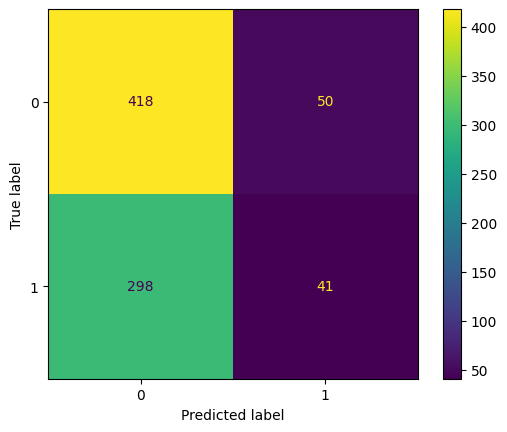

In [311]:
score, cm_7  = sign_match(clpusd_7_days_pred_df.loc[end_of_training:]['y_true'], 
                       clpusd_7_days_pred_df.loc[end_of_training:]['y_pred'],
                       return_matrix=True)

ConfusionMatrixDisplay(cm_7).plot()

### 3.2 shaply value

In [183]:
# SHAPLY VALUE
import shap
explainer = shap.Explainer(clpusd_7_days_model, X_holdout_7_scaled)
shap_values_xgb = explainer(X_holdout_7_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


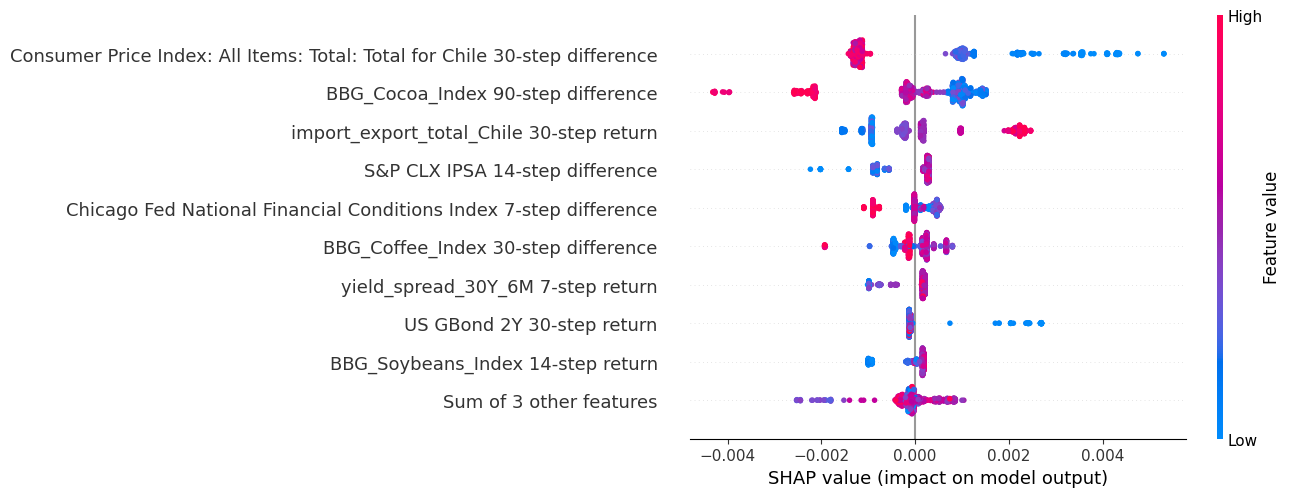

In [186]:
shap.plots.beeswarm(shap_values_xgb)

In [325]:
explainer = shap.Explainer(clpusd_30_days_model, X_holdout_30_scaled)
shap_values_xgb = explainer(X_holdout_30_scaled, check_additivity=False)

 98%|===================| 793/806 [00:40<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


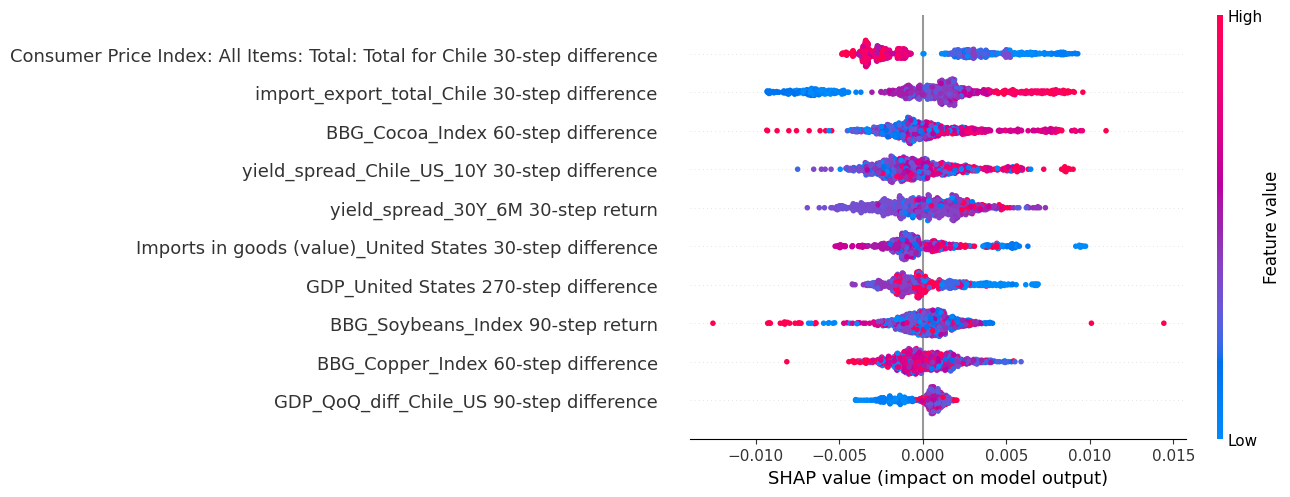

In [326]:
shap.plots.beeswarm(shap_values_xgb)

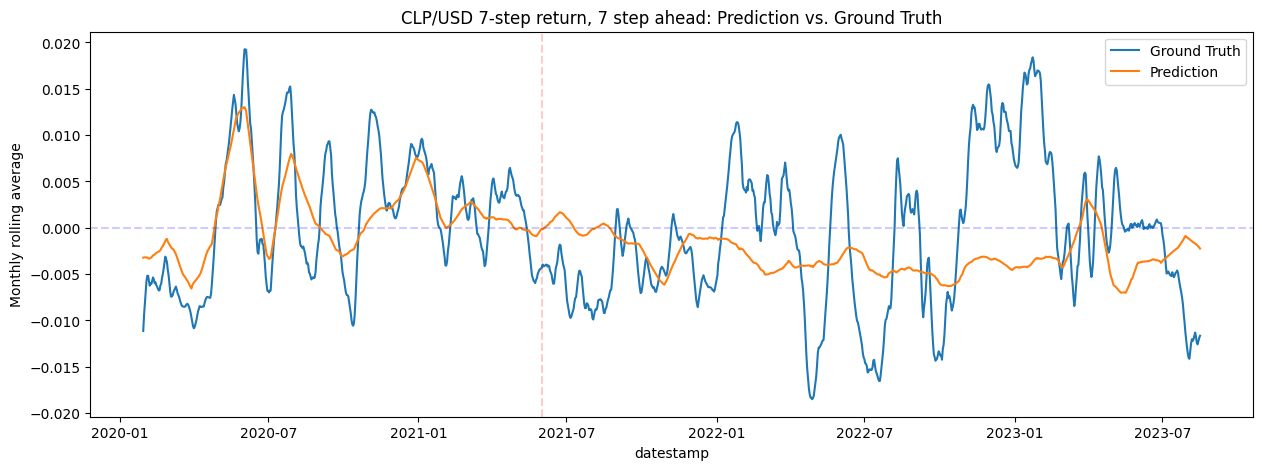

In [305]:
## 2013
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(clpusd_7_days_pred_df['y_true'].loc['2020-01-01':].rolling(30).mean(), label='Ground Truth')
plt.plot(clpusd_7_days_pred_df['y_pred'].loc['2020-01-01':].rolling(30).mean(), label='Prediction')
plt.title('CLP/USD 7-step return, 7 step ahead: Prediction vs. Ground Truth')
plt.xlabel('datestamp')
plt.ylabel('Monthly rolling average')
plt.legend()
plt.axvline(x=pd.to_datetime(end_of_training), color='red', linestyle='--', alpha = 0.2)
plt.axhline(y=0, color='blue', linestyle='--', alpha = 0.2)

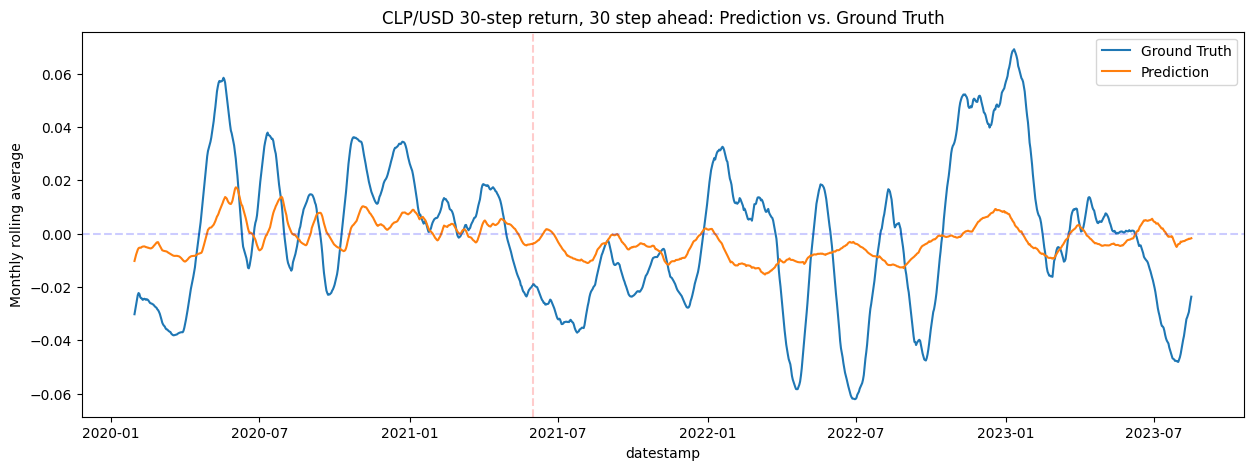

In [327]:
## 2013
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(clpusd_30_days_pred_df['y_true'].loc['2020-01-01':].rolling(30).mean() , label='Ground Truth')
plt.plot(clpusd_30_days_pred_df['y_pred'].loc['2020-01-01':].rolling(30).mean(), label='Prediction')
plt.xlabel('datestamp')
plt.ylabel('Monthly rolling average')
plt.title('CLP/USD 30-step return, 30 step ahead: Prediction vs. Ground Truth')
plt.xlabel('datestamp')
plt.ylabel('Monthly rolling average')
plt.legend()
plt.axvline(x=pd.to_datetime(end_of_training), color='red', linestyle='--', alpha = 0.2)
plt.axhline(y=0, color='blue', linestyle='--', alpha = 0.2)